<a href="https://colab.research.google.com/github/shashankgd/MelonomaDetectionCaseStudy/blob/master/MelonamaDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Problem_Statement:

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Importing Skin Cancer Data
Take necessary actions to read the data


Data Reading and Understanding

In [3]:
# from google.colab import drive
# drive.mount('/content/drive') # mount google drive to colab

Mounted at /content/drive


In [4]:
import os
current_dir = os.path.join('drive', 'MyDrive', 'Colab Notebooks', 'MelonamaDetection') # Skin cancer ISIC The International Skin Imaging Collaboration
os.chdir(current_dir)


In [5]:
data_path = 'SkincancerISICTheInternationalSkinImagingCollaboration'


Classes in the dataset: ['pigmented benign keratosis', 'seborrheic keratosis', 'basal cell carcinoma', 'squamous cell carcinoma', 'melanoma', 'actinic keratosis', 'nevus', 'vascular lesion', 'dermatofibroma']
Training Images per class:
pigmented benign keratosis: 462
seborrheic keratosis: 77
basal cell carcinoma: 376
squamous cell carcinoma: 181
melanoma: 438
actinic keratosis: 114
nevus: 367
vascular lesion: 139
dermatofibroma: 95


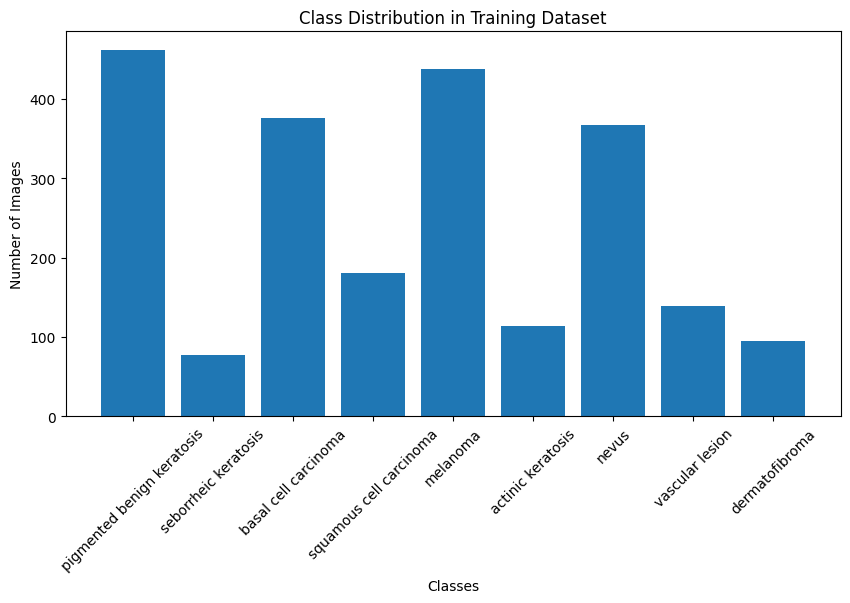

In [6]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

# Define paths for train and test datasets
train_dir = os.path.join(data_path, 'Train')
test_dir = os.path.join(data_path, 'Test')

# List all the classes (subfolders in the train directory)
classes = os.listdir(train_dir)
print(f"Classes in the dataset: {classes}")

# Count the number of images in each class
train_image_count = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
print("Training Images per class:")
for cls, count in train_image_count.items():
    print(f"{cls}: {count}")

# Visualize class distribution
plt.figure(figsize=(10, 5))
plt.bar(train_image_count.keys(), train_image_count.values())
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

### Dataset Creation


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (180, 180)

train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,         # Splitting out a validation set from train
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  # Typically you may not want to shuffle test data
)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.
Found 2249 files belonging to 9 classes.
Using 449 files for validation.
Found 118 files belonging to 9 classes.


### Dataset Visualization


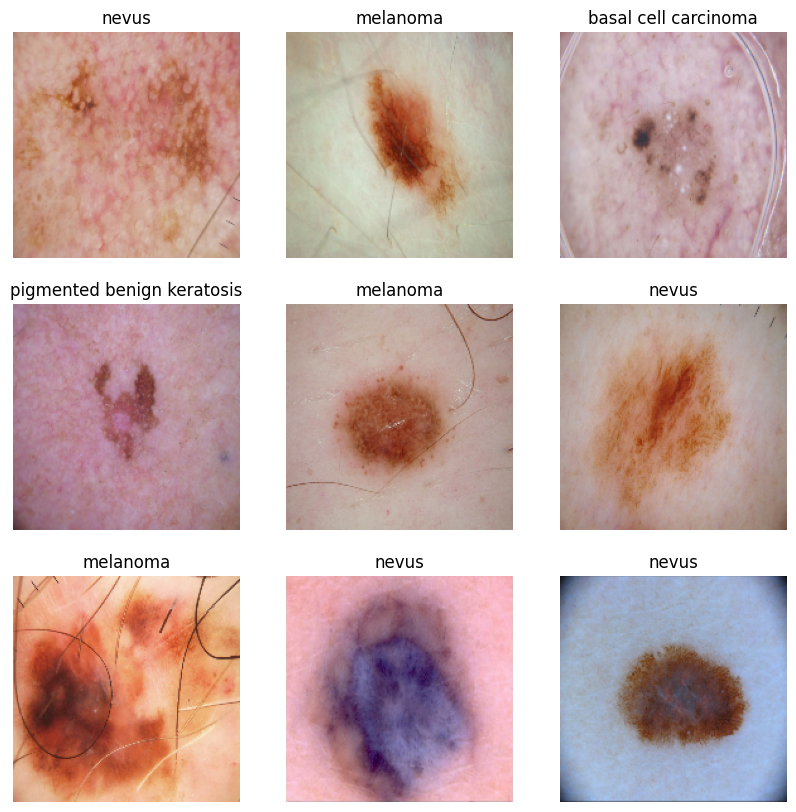

In [8]:
import matplotlib.pyplot as plt

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):  # one sample per class
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Model Building (Initial Custom CNN) & Training

#### Model Definition

In [26]:
from tensorflow.keras import layers, models

def create_model(num_classes=9, input_shape=(180, 180, 3)):
    model = models.Sequential([
        # Rescale layer to normalize pixel values
        layers.Input(shape=(180, 180, 3)),
        layers.Rescaling(1./255),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),  # helps reduce overfitting
        layers.Dense(num_classes, activation='softmax')  # 9 classes
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model(num_classes=len(class_names))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the Model

In [ ]:
EPOCHS = 20

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 326s 6s/step - accuracy: 0.2587 - loss: 2.0834 - val_accuracy: 0.3831 - val_loss: 1.7487
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 79s 383ms/step - accuracy: 0.3851 - loss: 1.6708 - val_accuracy: 0.4477 - val_loss: 1.6103
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 352ms/step - accuracy: 0.4874 - loss: 1.4859 - val_accuracy: 0.5033 - val_loss: 1.4400
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step - accuracy: 0.4987 - loss: 1.4260 - val_accuracy: 0.5212 - val_loss: 1.3560
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.5460 - loss: 1.3089 - val_accuracy: 0.5056 - val_loss: 1.3568
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step - accuracy: 0.5469 - loss: 1.2584 - val_accuracy: 0.5345 - val_loss: 1.4183
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - accuracy: 0.5830 - loss: 1.2264 - val_accuracy: 0.5323 - val_loss: 1.3821
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.5820 - loss: 1.1435 - val_accura

#### Initial Findings

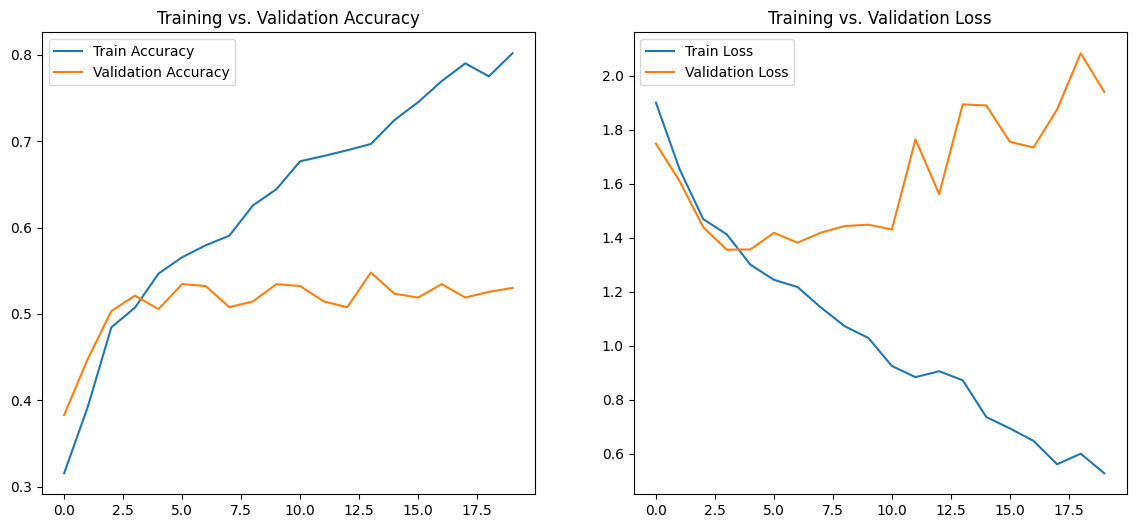

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

plt.show()

The model is overfitting as If training accuracy >> validation accuracy, and training loss << validation loss.

### Data Augmentation to Address Overfitting

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# Data augmentation pipeline
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

# Apply data augmentation only on training images
augmented_train_dataset = (
    train_dataset
    .map(lambda x, y: (data_augmentation(x, training=True), y))
)

In [ ]:
model_aug = create_model(num_classes=len(class_names))

EPOCHS = 20
history_aug = model_aug.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/20
57/57 [==============================] - 113s 2s/step - loss: 2.1052 - accuracy: 0.1867 - val_loss: 1.9912 - val_accuracy: 0.2094
Epoch 2/20
57/57 [==============================] - 106s 2s/step - loss: 1.9115 - accuracy: 0.2989 - val_loss: 1.7350 - val_accuracy: 0.4298
Epoch 3/20
57/57 [==============================] - 105s 2s/step - loss: 1.6593 - accuracy: 0.4189 - val_loss: 1.5967 - val_accuracy: 0.4588
Epoch 4/20
57/57 [==============================] - 105s 2s/step - loss: 1.5413 - accuracy: 0.4561 - val_loss: 1.5730 - val_accuracy: 0.4454
Epoch 5/20
57/57 [==============================] - 105s 2s/step - loss: 1.5846 - accuracy: 0.4389 - val_loss: 1.5310 - val_accuracy: 0.4521
Epoch 6/20
57/57 [==============================] - 104s 2s/step - loss: 1.4314 - accuracy: 0.4939 - val_loss: 1.4236 - val_accuracy: 0.4922
Epoch 8/20
57/57 [==============================] - 104s 2s/step - loss: 1.4129 - accuracy: 0.5106 - val_loss: 1.4177 - val_accuracy: 0.4989
Epoch 9/20
57

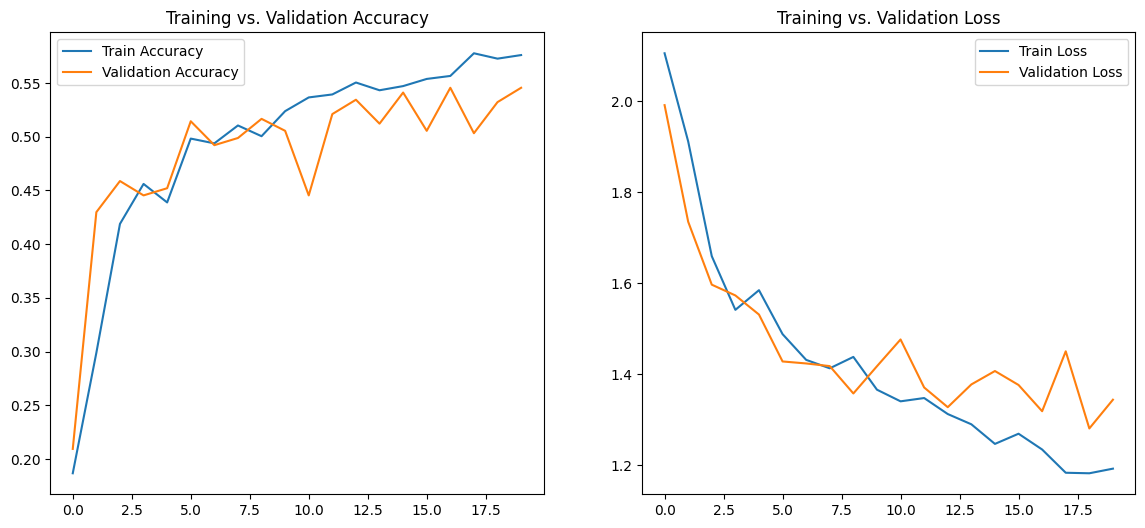

In [ ]:
import matplotlib.pyplot as plt

acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

plt.show()

###  Class Distribution Examination

In [11]:
import glob

for class_name in class_names:
    images_path = os.path.join(train_dir, class_name, '*.jpg')
    count = len(glob.glob(images_path))
    print(f"{class_name}: {count} images")

actinic keratosis: 114 images
basal cell carcinoma: 376 images
dermatofibroma: 95 images
melanoma: 438 images
nevus: 367 images
pigmented benign keratosis: 462 images
seborrheic keratosis: 77 images
squamous cell carcinoma: 181 images
vascular lesion: 139 images


class distribution is clearly imbalanced—for instance, Seborrheic keratosis has only 77 images while Pigmented benign keratosis has 462.

Write your findings here:
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?
Observations:

A clear class imbalance is evident within the training data.

The class "seborrheic keratosis" comprises the smallest proportion of samples, accounting for approximately 3.44%.

"Pigmented benign keratosis" and "melanoma" significantly outweigh other classes, representing approximately 20.63% and 19.56% of the data, respectively.


In [12]:
from sklearn.utils import class_weight
import numpy as np

# Suppose 'train_dataset' yields (images, labels)
all_labels = []
for _, labels in train_dataset.unbatch():
    all_labels.append(labels.numpy())

class_weights_dict = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights_dict = {i : w for i, w in enumerate(class_weights_dict)}


In [14]:
EPOCHS = 20

# Then pass class_weights_dict:
history_balanced = model.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.1356 - loss: 2.5432 - val_accuracy: 0.0980 - val_loss: 2.1970
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 67s 513ms/step - accuracy: 0.1495 - loss: 2.1086 - val_accuracy: 0.1225 - val_loss: 2.1985
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 479ms/step - accuracy: 0.1477 - loss: 2.1393 - val_accuracy: 0.2094 - val_loss: 2.0520
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 486ms/step - accuracy: 0.1942 - loss: 2.0233 - val_accuracy: 0.1871 - val_loss: 1.9588
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 468ms/step - accuracy: 0.1511 - loss: 2.0715 - val_accuracy: 0.2205 - val_loss: 2.1305
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 443ms/step - accuracy: 0.2045 - loss: 1.9869 - val_accuracy: 0.2138 - val_loss: 1.9658
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 479ms/step - accuracy: 0.2311 - loss: 1.8917 - val_accuracy: 0.2027 - val_loss: 1.8868
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 477ms/step - accuracy: 0.2274 - loss: 1.8066 - val_accura

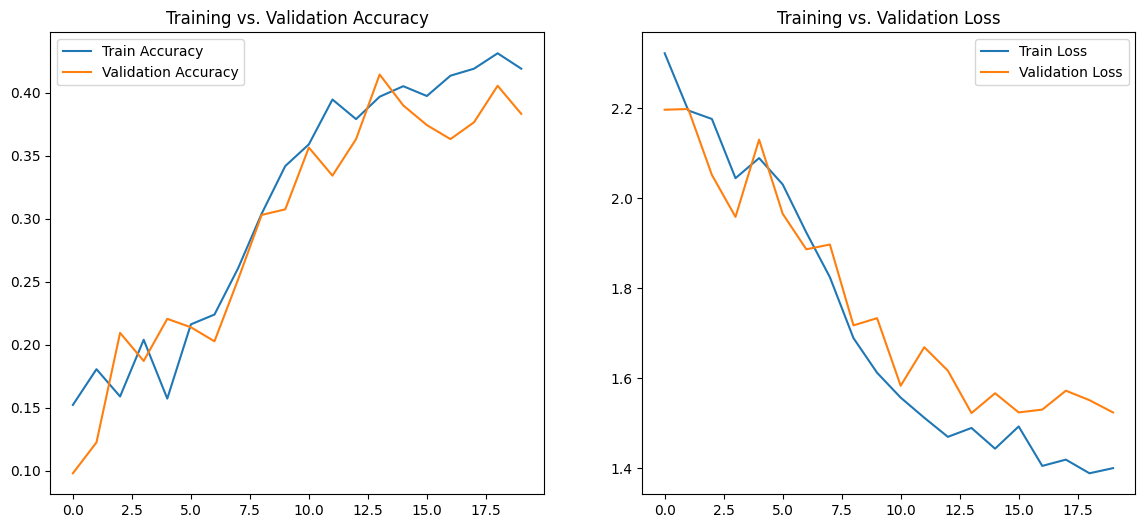

In [15]:
import matplotlib.pyplot as plt

acc = history_balanced.history['accuracy']
val_acc = history_balanced.history['val_accuracy']
loss = history_balanced.history['loss']
val_loss = history_balanced.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

plt.show()

Preprocessing and Augmentation Code

#### Model Evaluation


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


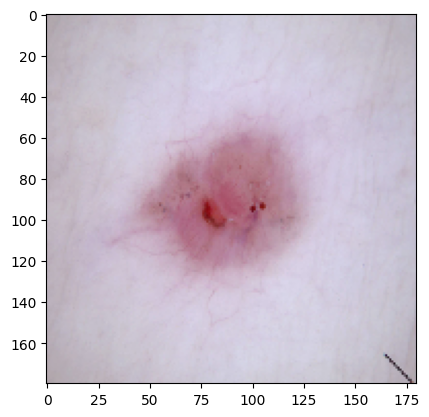

In [16]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img
from glob import glob


image_path_test = os.path.join(test_dir, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)

### Save model

In [17]:
model.save("my_model.h5")

### Load Model

In [18]:
# model = tf.keras.models.load_model("my_model.h5")

### Evaluate Model Accuracy on the Test Set

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.3171 - loss: 2.3056
Test Loss: 2.2174
Test Accuracy: 0.3475


### Confusion Matrix

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

all_preds = []
all_labels = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    preds = np.argmax(predictions, axis=1)
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Classification Report
class_names = test_dataset.class_names  # automatically derived from folder names
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Confusion Matrix:
 [[ 5  3  3  0  2  2  1  0  0]
 [ 2  3  7  0  0  3  1  0  0]
 [ 3  1  5  0  3  0  3  0  1]
 [ 0  0  0  4  6  6  0  0  0]
 [ 0  0  0  0 14  2  0  0  0]
 [ 4  2  1  0  1  5  0  3  0]
 [ 0  0  1  0  0  0  2  0  0]
 [ 0  3  4  0  4  3  0  1  1]
 [ 1  0  0  0  0  0  0  0  2]]
Classification Report:
                             precision    recall  f1-score   support

         actinic keratosis       0.33      0.31      0.32        16
      basal cell carcinoma       0.25      0.19      0.21        16
            dermatofibroma       0.24      0.31      0.27        16
                  melanoma       1.00      0.25      0.40        16
                     nevus       0.47      0.88      0.61        16
pigmented benign keratosis       0.24      0.31      0.27        16
      seborrheic keratosis       0.29      0.67      0.40 

A 35% overall accuracy and very low recall for critical classes (like melanoma at 0.25) indicates that your model isn’t sufficiently robust yet.

### Lets increase augumentaion

In [24]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    RandomFlip, RandomRotation, RandomZoom,
    RandomContrast, RandomTranslation
)

data_augmentation = Sequential([
    # Flip horizontally and possibly vertically if valid for your data
    RandomFlip("horizontal_and_vertical"),
    # Rotate up to ±20%
    RandomRotation(0.2),
    # Zoom in or out by up to 20%
    RandomZoom(0.2),
    # Translate images horizontally & vertically by up to 10%
    RandomTranslation(0.1, 0.1),
    # Adjust contrast up to ±10%
    RandomContrast(0.1),
])

augmented_train_dataset2 = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [27]:
EPOCHS = 20

# Then pass class_weights_dict:
history_aug2 = model.fit(
    augmented_train_dataset2,
    validation_data=val_dataset,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 606ms/step - accuracy: 0.1648 - loss: 2.5016 - val_accuracy: 0.1492 - val_loss: 2.0737
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 616ms/step - accuracy: 0.2045 - loss: 2.0778 - val_accuracy: 0.0780 - val_loss: 2.0685
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 580ms/step - accuracy: 0.2259 - loss: 1.9752 - val_accuracy: 0.1670 - val_loss: 1.9720
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 619ms/step - accuracy: 0.2485 - loss: 1.7857 - val_accuracy: 0.3140 - val_loss: 1.7866
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 621ms/step - accuracy: 0.3110 - loss: 1.6756 - val_accuracy: 0.3563 - val_loss: 1.6981
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 577ms/step - accuracy: 0.3151 - loss: 1.7003 - val_accuracy: 0.3653 - val_loss: 1.6923
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 580ms/step - accuracy: 0.3610 - loss: 1.6148 - val_accuracy: 0.3385 - val_loss: 1.7107
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 618ms/step - accuracy: 0.3418 - loss: 1.5446 - val_accu

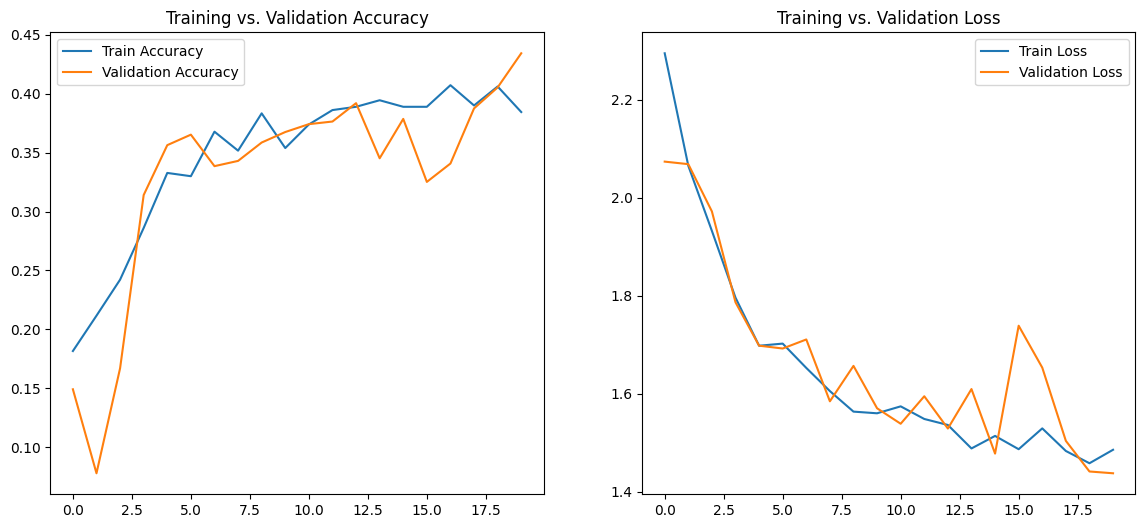

In [28]:
import matplotlib.pyplot as plt

acc = history_aug2.history['accuracy']
val_acc = history_aug2.history['val_accuracy']
loss = history_aug2.history['loss']
val_loss = history_aug2.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

plt.show()

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

all_preds = []
all_labels = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    preds = np.argmax(predictions, axis=1)
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Classification Report
class_names = test_dataset.class_names  # automatically derived from folder names
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Confusion Matrix:
 [[ 9  0  1  0  2  3  0  0  1]
 [ 3  4  5  0  0  3  1  0  0]
 [ 1  3  2  0  3  3  3  0  1]
 [ 2  0  0  1  9  3  0  0  1]
 [ 0  0  0  0 15  1  0  0  0]
 [ 1  2  0  0  1 12  0  0  0]
 [ 0  1  0  0  0  0  2  0  0]
 [ 1  3  1  1  3  4  0  2  1]
 [ 0  1  0  0  0  0  0  0  2]]
Classification Report:
                             precision    recall  f1-score   support

         actinic keratosis       0.53      0.56      0.55        16
      basal cell carcinoma       0.29      0.25      0.27        16
            dermatofibroma       0.22      0.12      0.16        16
                  melanoma       0.50      0.06      0.11        16
                     nevus       0.45      0.94      0.61        16
pigmented benign keratosis       0.41      0.75      0.53        16
      seborrheic keratosis       0.33      0.67      0.44

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',      # What metric to monitor
    patience=3,                  # Stop if no improvement for 3 epochs
    restore_best_weights=True    # Optionally restore the best model weights
)

In [33]:
model.save("my_model2.h5")

In [34]:
EPOCHS = 50

# Then pass class_weights_dict:
history_aug2 = model.fit(
    augmented_train_dataset2,
    validation_data=val_dataset,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[early_stop]

)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 627ms/step - accuracy: 0.4078 - loss: 1.3354 - val_accuracy: 0.3430 - val_loss: 1.6222
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 624ms/step - accuracy: 0.3937 - loss: 1.3781 - val_accuracy: 0.3675 - val_loss: 1.6259
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 34s 600ms/step - accuracy: 0.4150 - loss: 1.4593 - val_accuracy: 0.4143 - val_loss: 1.4599
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 583ms/step - accuracy: 0.3758 - loss: 1.3592 - val_accuracy: 0.3942 - val_loss: 1.4400
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 617ms/step - accuracy: 0.4380 - loss: 1.3455 - val_accuracy: 0.3786 - val_loss: 1.5069
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 34s 581ms/step - accuracy: 0.4143 - loss: 1.3306 - val_accuracy: 0.3853 - val_loss: 1.5167


In [37]:
history_aug2

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

all_preds = []
all_labels = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    preds = np.argmax(predictions, axis=1)
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Classification Report
class_names = test_dataset.class_names  # automatically derived from folder names
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Confusion Matrix:
 [[ 4  2  5  0  1  2  1  0  1]
 [ 0  3  8  0  0  4  1  0  0]
 [ 3  2  3  0  2  1  3  1  1]
 [ 1  1  0  2 10  2  0  0  0]
 [ 0  0  0  0 15  1  0  0  0]
 [ 0  2  1  0  1 12  0  0  0]
 [ 0  1  0  0  0  0  2  0  0]
 [ 0  5  1  1  3  3  1  1  1]
 [ 0  1  0  0  0  0  0  0  2]]
Classification Report:
                             precision    recall  f1-score   support

         actinic keratosis       0.50      0.25      0.33        16
      basal cell carcinoma       0.18      0.19      0.18        16
            dermatofibroma       0.17      0.19      0.18        16
                  melanoma       0.67      0.12      0.21        16
                     nevus       0.47      0.94      0.62        16
pigmented benign keratosis       0.48      0.75      0.59        16
      seborrheic keratosis       0.25      0.67      0.36

	Model Melanoma Detection Report
	•	Precision is quite high (0.67), but recall is only 0.12.
	•	This means that when the model predicts “melanoma,” it’s often correct, but it fails to catch most melanomas. Out of 16 true melanomas, only about 2 are identified correctly. In a clinical context, this low recall is problematic—you’re missing a large majority of true melanoma cases.


In [39]:
model.save("my_model3.h5")